In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
from tensorflow import keras
import hydroeval as he

In [215]:
# reading data
df_b = pd.read_csv("data/basel.csv", index_col=0)
df_b.tail()

,datetime,et,p,t,obs
7300,2000-12-27,0.000492,0.001242,2.119268,662.035
7301,2000-12-28,0.000413,0.000561,-0.594725,656.253
7302,2000-12-29,0.000348,0.002027,-3.251007,652.150
7303,2000-12-30,0.000306,0.000741,-5.414832,641.549
7304,2000-12-31,0.000274,0.000000,-7.274929,599.663


In [216]:
# inspecting data
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [217]:
q_basel = pd.read_csv("data/q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
# making date time the index of data
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [218]:
# make the date column index
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

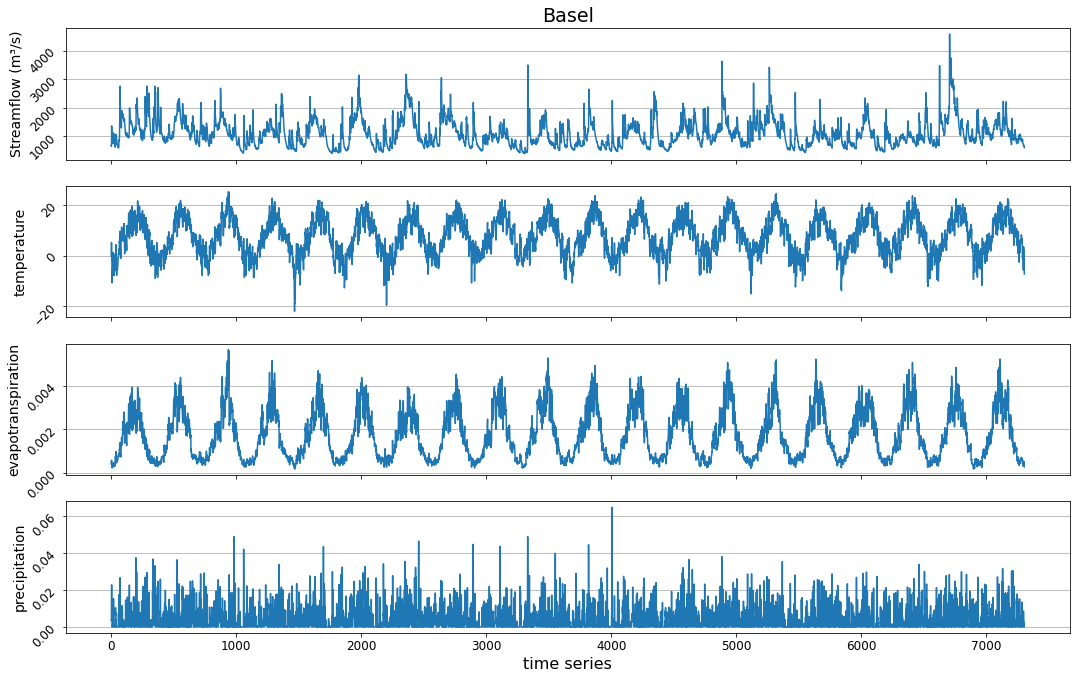

In [219]:
# plot data
shown_data = 0.5

# variables to plot
obs_b = df_basel.obs.values
t_b = df_basel.t.values
et_b = df_basel.et.values
p_b = df_basel.p.values


# plot the variables
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(obs_b)
ax2.plot(t_b)
ax3.plot(et_b)
ax4.plot(p_b)


#set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]

#tweak the axes
ax1.title.set_text('Basel')
ax4.set_xlabel('time series')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax2.set_ylabel('temperature', fontsize = 14)
ax3.set_ylabel('evapotranspiration', fontsize = 14)
ax4.set_ylabel('precipitation', fontsize = 14)

for ax in (ax1, ax2, ax3, ax4):
  ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)

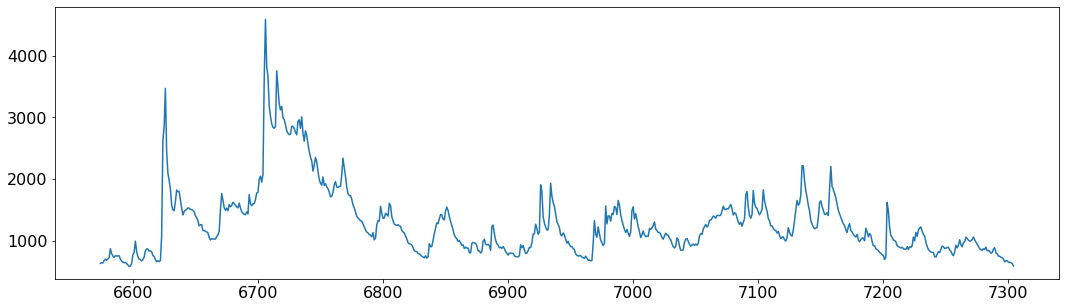

In [220]:
# plot last two years
df_b_new = df_b.loc[(df_b['datetime'] >= '1999-01-01') & (df_b['datetime'] <= '2000-12-31')]
plt.figure(figsize=(18, 5))
fig = plt.plot(df_b_new.obs)

# Data Prep

In [221]:
# train test split
len_ = int(0.75 * df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [222]:
# x  and y train
X_train = df_train[["et","t","p"]]
y_train = df_train.obs

# x and y test
X_test = df_test[["et","t","p"]]
y_test = df_test.obs

In [223]:
# normalising data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [224]:
y_train.shape[0]

5478

In [226]:
# normalize output
y_train_shaped = np.reshape(y_train.values, (y_train.shape[0],1))
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)
y_test_shaped = np.reshape(y_test.values, (y_test.shape[0],1))
y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(1827, 1)

## Hyperparameter Optimization

In [227]:
# https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00

def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [231]:
num_steps = 50

# training set
# training set
(X_train_transformed,
 y_train_transformed) = lstm_data_transform(X_train, y_train_scaled, num_steps=num_steps)
assert X_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(X_test_transformed,
 y_test_transformed) = lstm_data_transform(X_test, y_test_scaled, num_steps=num_steps)
assert X_test_transformed.shape[0] == y_test_transformed.shape[0]


In [232]:
X_train_transformed.shape

(5428, 50, 3)

In [233]:
y_test_transformed.shape

(1777, 1)

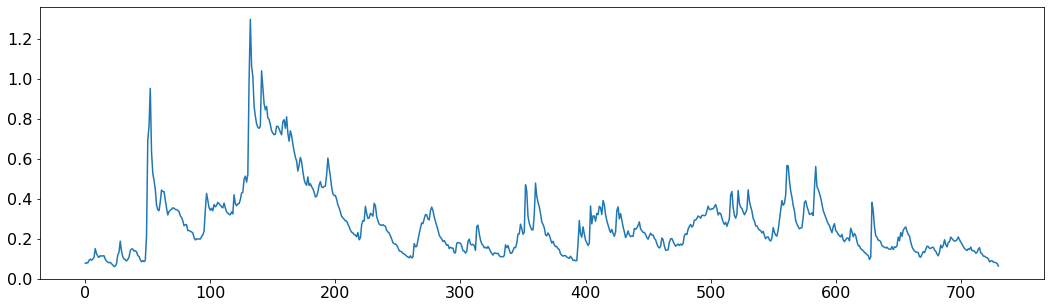

In [234]:
# df_b_new = pred.loc[(pred['datetime'] >= '1999-01-01') & (df_b['datetime'] <= '2000-12-31')]
plt.figure(figsize=(18, 5))
fig = plt.plot(y_test_transformed[-731:])

In [235]:
y_train_transformed.shape

(5428, 1)

In [143]:
# batch_size = 1000
# num_features = 3
# new_array = np.asarray(X_train).reshape(batch_size,time_step,X_train.shape[1])
# new_array

In [144]:
# reshape_arr = np.expand_dims(X_train,(batch_size,time_step,X_train.shape[1]))
# reshape_arr.shape

### A random model

In [236]:
%%time
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1234)

def init_model():

    model = Sequential()
    model.add(LSTM(200, activation='relu',input_shape =(X_train_transformed.shape[1],3), return_sequences=True)) # input shape?? input_shape =(X_train_scaled.shape[1],3)
    model.add(Dropout(0.1)) # decrease this
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(200, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1,activation='linear')) # activation = linear

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])

    return model



model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model.fit(X_train_transformed, y_train_transformed,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
136/136 [==============================] - 91s 632ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 2/1000
136/136 [==============================] - 101s 746ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3/1000
136/136 [==============================] - 101s 739ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/1000
136/136 [==============================] - 101s 746ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 5/1000
136/136 [==============================] - 103s 754ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/1000
136/136 [==============================] - 103s 759ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/1000
136/136 [==============================] - 101s 745ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/1000
136/136 [=============

In [237]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 50, 200)           163200    
                                                                 
 dropout_18 (Dropout)        (None, 50, 200)           0         
                                                                 
 lstm_26 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dropout_19 (Dropout)        (None, 50, 200)           0         
                                                                 
 lstm_27 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dropout_20 (Dropout)        (None, 50, 200)           0         
                                                                 
 lstm_28 (LSTM)              (None, 200)              

In [238]:
res = model.evaluate(X_test_transformed, y_test_transformed, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0071


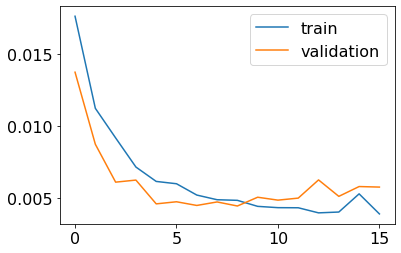

In [239]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [240]:
y_pred = model.predict(X_test_transformed)

nse = he.evaluator(he.nse,y_pred,y_test_transformed)
nse[0]

0.6614132791818114

In [241]:
# kge evaluation
kge = he.evaluator(he.kge, y_pred, y_test_transformed)
kge[0]

array([0.67895212])

## Hyperparameter Optimization

In [242]:
import keras_tuner as kt
from tensorflow import keras


# define the baseline model
def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01, 0.001])), metrics = ['mse'])
    return model

In [243]:
# instantiate the Hyperband tuner
tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations = 1,
                     directory='hyperparameter_tunning_2',
                     project_name='LSTM_Basel_hyperparameter_tunning')

In [244]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the tuner
tuner.search(X_train_transformed, y_train_transformed, epochs=25, validation_split=0.2, callbacks=[es])

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

Trial 16 Complete [00h 13m 58s]
mse: 0.007266074884682894

Best mse So Far: 0.006373235955834389
Total elapsed time: 03h 17m 08s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
320               |320               |input_unit
2                 |2                 |n_layers
416               |416               |lstm_0_units
320               |320               |layer_2_neurons
0                 |0                 |Dropout_rate
tanh              |tanh              |dense_activation
0.001             |0.001             |learning_rate
480               |480               |lstm_1_units
256               |256               |lstm_2_units
96                |96                |lstm_3_units
20                |7                 |tuner/epochs
7                 |3                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
0013              |0009              |tuner/trial_id

Epoch 8/20
13

KeyboardInterrupt: 

In [148]:
# geting optimal params in a dict to save it
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# reading optimal params in a df
dict_ = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
lstm_best_params = pd.DataFrame([dict_])
lstm_best_params

,input_unit,n_layers,lstm_0_units,layer_2_neurons,Dropout_rate,dense_activation,learning_rate,lstm_1_units,lstm_2_units,lstm_3_units,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id
0,128,2,320,352,0.2,relu,0.01,64,256,320,20,7,2,2,0013


In [ ]:
# run this later
lstm_best_params.to_csv("lstm_best_params.csv")

## Single Model Run

In [149]:
%%time

# building the model based on optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the model
history = best_model.fit(X_train_transformed, y_train_transformed,
            validation_split= 0.2,
            epochs=1000,
            batch_size= 32, # tried it with 16 | 128  | 512
            callbacks=[es])

Epoch 1/1000
136/136 [==============================] - 137s 941ms/step - loss: 973543.0000 - mse: 973543.0000 - val_loss: 758279.6875 - val_mse: 758279.6875
Epoch 2/1000
136/136 [==============================] - 133s 981ms/step - loss: 493788.2812 - mse: 493788.2812 - val_loss: 410809.9375 - val_mse: 410809.9375
Epoch 3/1000
136/136 [==============================] - 114s 836ms/step - loss: 296223.3125 - mse: 296223.3125 - val_loss: 271615.6250 - val_mse: 271615.6250
Epoch 4/1000
136/136 [==============================] - 113s 828ms/step - loss: 232208.9219 - mse: 232208.9219 - val_loss: 225718.0781 - val_mse: 225718.0781
Epoch 5/1000
136/136 [==============================] - 109s 800ms/step - loss: 215978.2812 - mse: 215978.2812 - val_loss: 211571.9375 - val_mse: 211571.9375
Epoch 6/1000
136/136 [==============================] - 110s 809ms/step - loss: 213008.0469 - mse: 213008.0469 - val_loss: 207646.2031 - val_mse: 207646.2031
Epoch 7/1000
136/136 [==============================

In [150]:
# summary of the model
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 128)           67584     
                                                                 
 lstm_6 (LSTM)               (None, 50, 320)           574720    
                                                                 
 lstm_7 (LSTM)               (None, 50, 64)            98560     
                                                                 
 lstm_8 (LSTM)               (None, 352)               587136    
                                                                 
 dropout_1 (Dropout)         (None, 352)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 353       
                                                                 
Total params: 1,328,353
Trainable params: 1,328,353
No

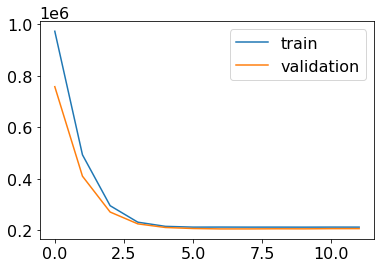

In [151]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Evaluation

In [152]:
# mse evaluation
res = best_model.evaluate(X_test_transformed, y_test_transformed, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 220028.1719


In [153]:
# nse evaluation
y_pred = best_model.predict(X_test_transformed)

nse = he.evaluator(he.nse,y_pred,y_test_transformed)
nse[0]

-8.88028122503215e-06

In [154]:
# kge evaluation
kge = he.evaluator(he.kge, y_pred, y_test_transformed)
kge[0]

C:\Users\Wescap\anaconda3\lib\site-packages\hydroeval\objective_functions.py:80: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


array([nan])

# Saving Model

In [155]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_2_new.h5")
print("Saved model to disk")

Saved model to disk


In [156]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2_new.h5")
print("Loaded model from disk")

OSError: Unable to open file (unable to open file: name = 'model_2_new.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# evaluate loaded model on test data
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loaded_model.compile(loss='mean_squared_error',optimizer= optimizer , metrics = ['mse'])
score = loaded_model.evaluate(X_test_transformed, y_test_transformed, verbose=0)
print(f'MSE on the test set : {res[1]:.4f}')

## Ensemble Runs

In [ ]:
%%time

# define a function to run the model multiple times
def train_multiple_times():
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model.fit(X_train_transformed, y_train_transformed,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32,
            callbacks=[es])
    y_pred = model.predict(X_test_transformed)
    # invert predictions
    y_pred_inversed = scaler.inverse_transform(y_pred)


    nse = he.evaluator(he.nse,y_pred,y_test_transformed)
    kge = he.evaluator(he.kge, y_pred, y_test_transformed)
    return (nse, kge[0], y_pred_inversed)


nse = []
kge = []
y_pred = []
repeats = 10

# a for loop for running model 10 times
for t in range(repeats):

    nse_multiple, kge_multiple, y_pred_inversed = train_multiple_times()
    nse.append(nse_multiple)
    kge.append(kge_multiple)
    y_pred.append(y_pred_inversed)

    print(f'For {t} time running model, the NSE is : {nse_multiple}')
    print(f'For {t} time running model, the KGE is : {kge_multiple}')

In [ ]:
# convert y_pred to an array
y_pred_array = np.array(y_pred)

# dimension of y_pred array
y_pred_array.shape

In [ ]:
# taking the mean of y_preds over 10 time predictions and saving it in a csv file
y_df = pd.DataFrame(y_pred_array.mean(axis=0))

# changing the name of the column
y_df.columns = ["y_pred"]

# saving the calculated mean to a csv file
y_df.to_csv("predicted/y_pred_lstm_10_new.csv")

In [ ]:
# double-check the mean of y_pred with another technique
np.save("predicted/y_pred_lstm_10_new.npy", y_pred_array, allow_pickle=True)
y_pred_loaded = np.load('predicted/y_pred_lstm_10_new.npy', allow_pickle=True)
y_pred_loaded.shape

In [ ]:
# save NSE

nse = np.array(nse)
np.save('predicted/nse_basel_ave_10_new.npy', nse, allow_pickle=True)

# best so far is nse_basel_3
nse_loaded = np.load('predicted/nse_basel_ave_10_new.npy',allow_pickle=True)

# means and sd of NSE
nse_mean = np.mean(nse_loaded)
nse_sd = np.std(nse_loaded)
print(f'mean NSE is : {nse_mean}')
print(f'Standard devation of NSE over 10 times running model is : {nse_sd}')

In [ ]:
# save KGE

kge = np.array(kge)
np.save('predicted/kge_basel_ave_10_new.npy', kge, allow_pickle=True)

kge_loaded = np.load('predicted/kge_basel_ave_10_new.npy',allow_pickle=True)

# means and sd of KGE
kge_mean = np.mean(kge_loaded)
kge_sd = np.std(kge_loaded)
print(f'mean KGE is : {kge_mean}')
print(f'Standard deviation of KGE over 10 times running model is : {kge_sd}')

## Prediction

In [ ]:
# useful link : https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
Y_df = pd.read_csv("predicted/y_pred_lstm_10.csv",index_col=0)
Y_pred = Y_df.y_pred.values

In [ ]:
# add date of prediction
# Y_df['date'] = pd.date_range(start = "1/1/1999", periods =731, freq = "D")
# Y_df

# PCR

In [ ]:
# getting the result of pcr model
pcr_pred = q_basel.pcr.values[len_:]

# train-test split
len_ = int(0.75*q_basel.shape[0])

y_train_pcr = q_basel.pcr[:len_]
y_test_pcr = q_basel.pcr[len_:]

# making data in right shape
# I need pcr y-test here which means y_test_pcr



## Plots

In [ ]:
# plot performance of model for year 1999-2000 and 2000-2001 in two different subplots
# variables to plot
Y_test = scaler.inverse_transform(y_test_transformed)
predicted = Y_df.y_pred
pcr_prediction = y_test_pcr
date = Y_df.date

# years to plot
date_1 = Y_df.date[:365]

date_2 = Y_df.date[365:]

# dividing variables to two years
actual_1 = Y_test[:365]
actual_2 = Y_test[365:]

predicted_1 = Y_df.y_pred[:365]
predicted_2 = Y_df.y_pred[365:]

pcr_prediction_1 = pcr_y_test[:365]
pcr_prediction_2 = pcr_y_test[365:]

# plot the variables
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(date_1, actual_1, "b",label ="obs")
ax1.plot(date_1, predicted_1, "g", label = "LSTM")
ax1.plot(date_1, pcr_prediction_1,"r", label = "PCR")
ax2.plot(date_2, actual_2,"b", date_2, predicted_2,"g", date_2, pcr_prediction_2, "r")

# #set the ticks
# days_per_year = [0]+[365, 365, 365, 366]*5
# ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]

#tweak the axes
ax1.title.set_text('Basel')
ax2.set_xlabel('time')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14) # maybe change the range of y axis so that you do not see so many variation
ax2.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax1.legend()

for ax in (ax1, ax2):
  #ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)
  ax.set_yticks(ticks= [1000,2000,3000,4000])

plt.savefig("figures/1999-2000_plot_new.png")